In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from taskdataset import TaskDataset
import torchvision
import cv2

path_to_data = "datasets/" # TODO Set path to datasets files
path_to_models = "models/"

# import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
# import torch.onnx
import onnx
import onnxscript
from torchsummary import summary

In [2]:
import pickle
import pandas as pd
dataset = pd.read_pickle(path_to_data + "data3.pck")

In [3]:

dataset2 = []

length = len(dataset)
# length = 100

for i in range(length):
    image = np.array(dataset['image'][i], dtype=np.uint8)


    if image.shape != (32, 32, 3):
        #convert to RGB
        # print(type(image[0]))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # print(image.shape)
    # image.astype(np.float32)
    #convert to tensor
    image = torch.from_numpy(image)

    image = image.to(torch.float32) / 255
    label = dataset['output'][i]
    # el = [image.reshape(3*32*32), label.astype(np.float32)]
    el = [image.reshape(3*32*32), label.astype(np.float32)]
    dataset2.append(el)
    # print(image)



In [4]:
dataset2[:80][0][0].shape
dataset2[:80][0][1].shape

val_split = 0.1
train_size = len(dataset2)
split = int(np.floor(val_split * train_size))
split
train_data = dataset2[split:]
val_data = dataset2[:split]

print(train_data[:80][0][0].shape)
train_data[:80][0][1].shape

torch.Size([3072])


(512,)

In [5]:
t_loader = torch.utils.data.DataLoader(dataset = train_data,
                                     batch_size = 32,
                                     shuffle = True)

v_loader = torch.utils.data.DataLoader(dataset = val_data,
                                     batch_size = 32,
                                     shuffle = True)

dataloaders = {'train': t_loader, 'val': v_loader}

In [6]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(

            torch.nn.Linear(3 * 32 * 32, 1536),
            torch.nn.ReLU(),
            torch.nn.Linear(1536, 1536),
            torch.nn.ReLU(),
            torch.nn.Linear(1536, 512),
            
        )
         
 
    def forward(self, x):
        # print(x)
        encoded = self.encoder(x)
        encoded.double()
        return encoded

In [7]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [8]:
epochs = 20
outputs = []
losses = []
all_losses = []
v_all_losses = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(epochs):
    
    print(f"\nEpoch {epoch+1} of {epochs}")
    print("-------------------------------")

    idx = -1

    mode = 'train'

    for loader in [t_loader, v_loader]:

      print(f"Load: {loader}")
      if mode == 'train':
        model.train()
        mode = 'val'
      else:
        model.eval()
        mode = 'train'

      for (image, labels) in loader:
        idx = idx + 1
        losses = []
        v_losses = []
        print(f"Epoch {epoch+1}, Bach {idx} of {len(loader)}")

        model.train()

        # Output of Autoencoder
        features = model(image)

        # Calculating the loss function
        loss = loss_function(features, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        

        # Storing the losses in a list for plotting
        if mode == 'train':
          losses.append(float(loss))
        elif type(float(loss)) is not np.nan:
          print(f"mode: {mode}, loss: {loss}")
          v_losses.append(float(loss))
        losses.append(float(loss))
      
      print(v_all_losses)
      all_losses.append(np.average(losses)) 
      v_all_losses.append(np.average(v_losses))


    torch.onnx.export(model,                                # model being run
                      torch.randn(3*32*32).to(device),    # model input (or a tuple for multiple inputs)
                      path_to_models + f"zad1_model_e{epoch}.onnx",           # where to save the model (can be a file or file-like object)
                      input_names = ['input'],              # the model's input names
                      output_names = ['output'])            # the model's output names
      
      
 




Epoch 1 of 20
-------------------------------
Load: <torch.utils.data.dataloader.DataLoader object at 0x000001B3C5B5F590>
Epoch 1, Bach 0 of 29


mode: val, loss: 1.4449810981750488
Epoch 1, Bach 1 of 29
mode: val, loss: 83347243008.0
Epoch 1, Bach 2 of 29
mode: val, loss: 3053208.5
Epoch 1, Bach 3 of 29
mode: val, loss: 24446.13671875
Epoch 1, Bach 4 of 29
mode: val, loss: 1274742.5
Epoch 1, Bach 5 of 29
mode: val, loss: 78988856.0
Epoch 1, Bach 6 of 29
mode: val, loss: 1764875.375
Epoch 1, Bach 7 of 29
mode: val, loss: 94938.3359375
Epoch 1, Bach 8 of 29
mode: val, loss: 651.182373046875
Epoch 1, Bach 9 of 29
mode: val, loss: 47716.0546875
Epoch 1, Bach 10 of 29
mode: val, loss: 156916.625
Epoch 1, Bach 11 of 29
mode: val, loss: 15181.6396484375
Epoch 1, Bach 12 of 29
mode: val, loss: 28801.654296875
Epoch 1, Bach 13 of 29
mode: val, loss: 3933.9150390625
Epoch 1, Bach 14 of 29
mode: val, loss: 72253.234375
Epoch 1, Bach 15 of 29
mode: val, loss: 19661.8359375
Epoch 1, Bach 16 of 29
mode: val, loss: 12443.849609375
Epoch 1, Bach 17 of 29
mode: val, loss: 84959.9453125
Epoch 1, Bach 18 of 29
mode: val, loss: 48296.44140625
Epoc

d:\programy\python3.11.6\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\programy\python3.11.6\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Epoch 2 of 20
-------------------------------
Load: <torch.utils.data.dataloader.DataLoader object at 0x000001B3C5B5F590>
Epoch 2, Bach 0 of 29
mode: val, loss: 16639.9609375
Epoch 2, Bach 1 of 29
mode: val, loss: 5121.10400390625
Epoch 2, Bach 2 of 29
mode: val, loss: 1306.9853515625
Epoch 2, Bach 3 of 29
mode: val, loss: 4589.72607421875
Epoch 2, Bach 4 of 29
mode: val, loss: 8344.1455078125
Epoch 2, Bach 5 of 29
mode: val, loss: 8129.13037109375
Epoch 2, Bach 6 of 29
mode: val, loss: 786.0443725585938
Epoch 2, Bach 7 of 29
mode: val, loss: 4662.63037109375
Epoch 2, Bach 8 of 29
mode: val, loss: 7011.20849609375
Epoch 2, Bach 9 of 29
mode: val, loss: 2733.44482421875
Epoch 2, Bach 10 of 29
mode: val, loss: 3080.755859375
Epoch 2, Bach 11 of 29
mode: val, loss: 2303.519287109375
Epoch 2, Bach 12 of 29
mode: val, loss: 167.7988739013672
Epoch 2, Bach 13 of 29
mode: val, loss: 2288.58935546875
Epoch 2, Bach 14 of 29
mode: val, loss: 952.8112182617188
Epoch 2, Bach 15 of 29
mode: val, l

In [11]:
for i in range(len(v_all_losses)):
    # print(v_all_losses[i])
    # print(type(v_all_losses[i]))
    if not v_all_losses[i] > 0.5:
        v_all_losses[i] = 0


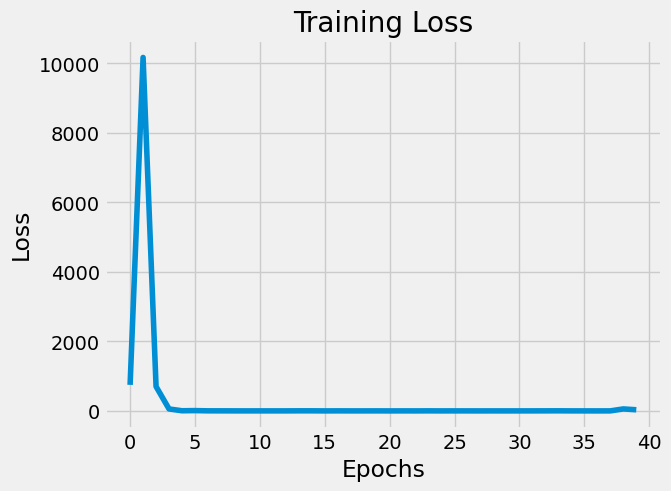

Text(0.5, 1.0, 'Validation Loss')

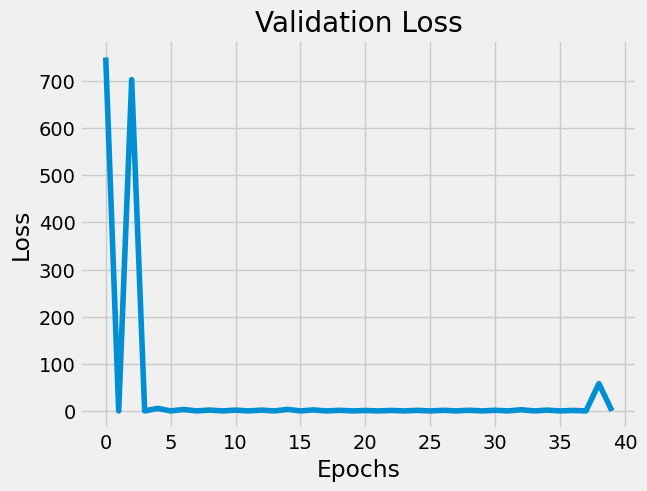

In [10]:

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.loglog(all_losses)
# losses2 = np.array(losses2)
 
# Plotting the last 100 values
plt.plot(all_losses)
plt.title('Training Loss')
# losses
plt.show()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(v_all_losses)
plt.title('Validation Loss')
# plt.axis([0, 10, 0, 1000000000])